# MLP language character-level language model
This is the second part of the building of makemore and is based on the lecture [The spelled-out intro to language modeling: building makemore. Part 2: MLP](https://www.youtube.com/watch?v=TCH_1BHY58I).

In the second lecture we implement a multi layer perceptron (MLP) character level language model. Furthermore we will introduce basics of machine learning (e.g. model training, learning rate tuning, hyperparameters, evaluation, train/dev/test splits, under/overfitting, etc.).

First we have a look at the [Bengio et al. 2003 MLP language model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) paper. They work with a vocabulary of 17k words, from which they build their *word*-level language model. We will use a *character*-level language model, but we'll use the same architecture.

To work with the words, they put every word in a *(eg.)* 30 dimensional vector, so they will end up with 17k datapoints in a 30 dimensional vectorspace. Over training vectors of familiar words will get close, vectors of synonyms will fully align and vectors of opposites will deiverge from each other *(See following Picture)*.

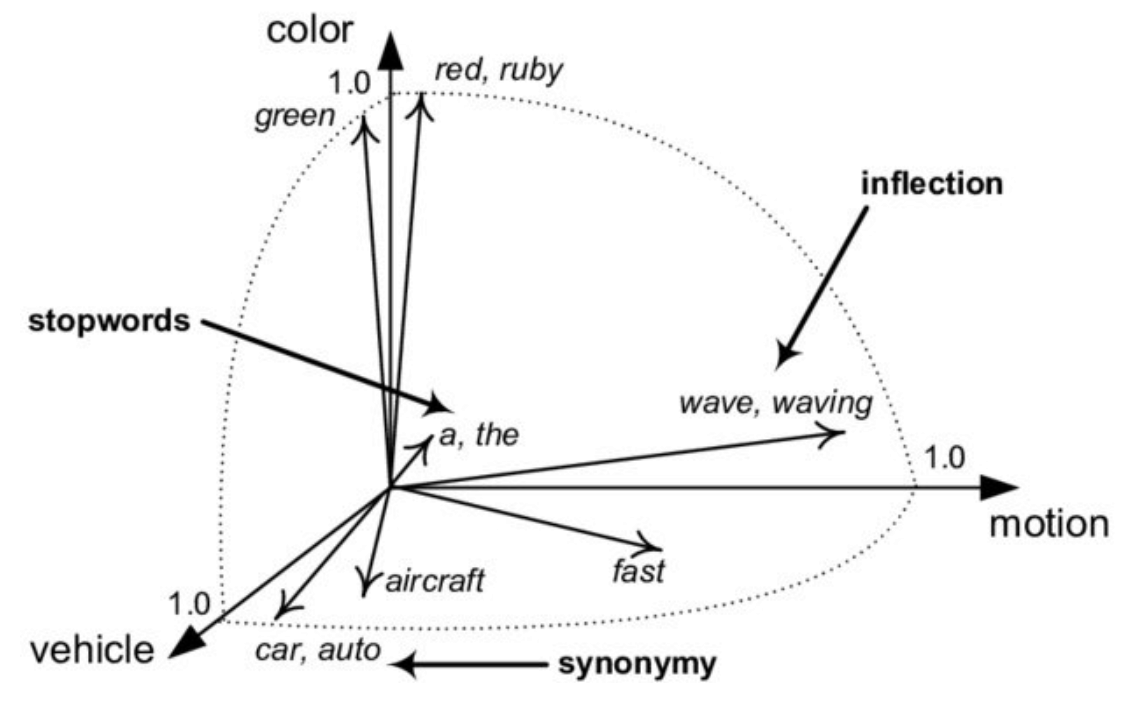


We use the same architecure for our character-level language model as they used for the word-level language model. Basically we will have 30 input neurons for the number of dimensions of our vector space. Next we have a hidden layer (size is up to the designer --> hyperparameter) which all are fully connected to all input neurons. On the output layer we have 27 neurons for all output characters which are all connected to all hidden neurons. So we have 27 logits here which are topped up with a softmax layer, so that we have a nice probability distribution for the next character in the sequence.

During training we have the lable of the next character and we are maximiseing the probability of that character with respect to the parameters (weights, biases, look-up-table) of this neural net using backpropagation.

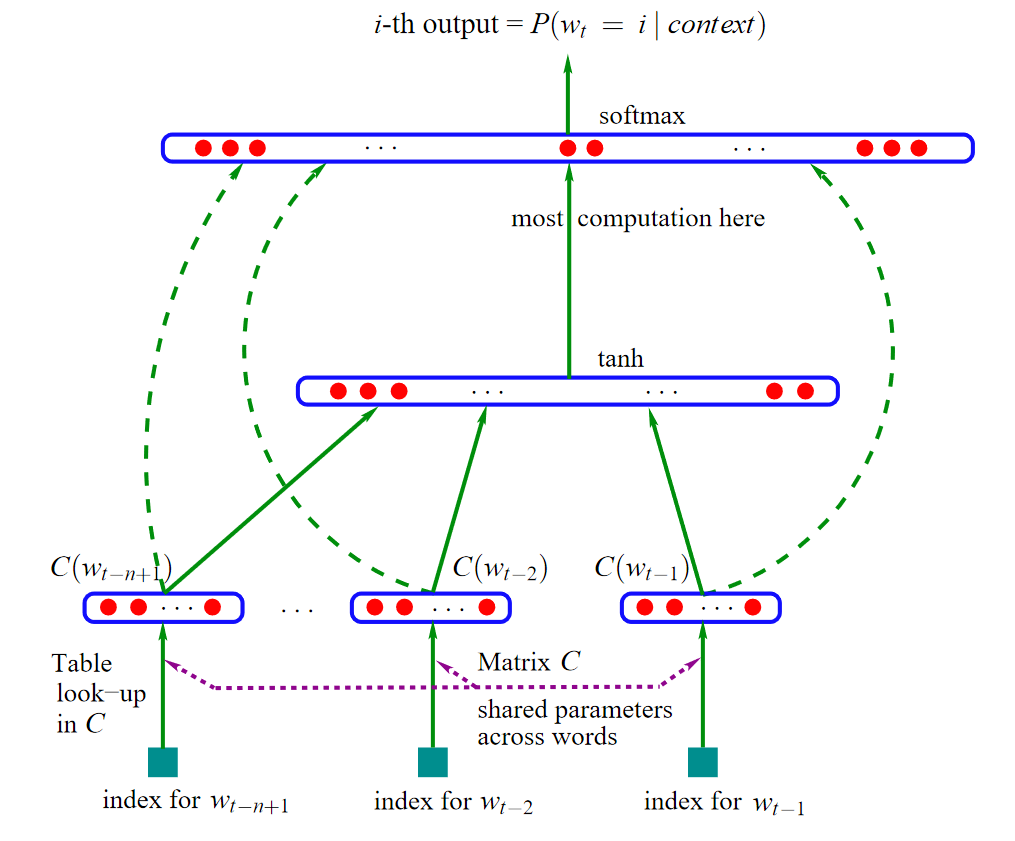

In [ ]:
import torch
import torch.nn.functional as F       # common way of import
import matplotlib.pyplot as plt
%matplotlib inline

# get Dataset
!wget https://raw.githubusercontent.com/AndreasMing/Learning/main/NN_Makemore/MakemoreNames.txt
words =  open('MakemoreNames.txt', 'r').read().splitlines()   # Import words into a python list

# character lookup table
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

## (re)building dataset
Taking the wordlist from above.

In [77]:
# build dataset
block_size = 3          # number of characters used to predict the next one
X, Y = [], []           # X: Input to the neural net, Y: Label for each example in X

for w in words[:]:
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]    # crop and append "rolling window"

X = torch.tensor(X)
Y = torch.tensor(Y)

In [78]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

## implement embedding look-up-table

In [34]:
C = torch.randn((27, 2))    # size of embedding: 2

Now there are two ways of embedding the integers:
```
C[5]
>>> tensor([ 0.0657, -0.9301])

F.one_hot(torch.tensor(5), num_classes=27).float() @ C
>>> tensor([ 0.0657, -0.9301])
```
As we can see we get the exact same result, because with one-hot wie get a matrix multiplication with a matrix with only one 1, so it's the same as indexing this in ``C`` directly.

In [35]:
emb = C[X]      # embedding of integers (32, 3, 2)

## implementing neural net
The neural net is implemented according to the architecture mentioned by the [Bengio et al. 2003 MLP language model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) paper.

In [ ]:
# hidden layer of nn
W1 = torch.randn(6, 100)      # number of inputs (3 char x 2 dim embedding = 6), hyperparameter 100 neurons
b1 = torch.randn(100)

Check out a short side note on [PyTorch internals](http://blog.ezyang.com/2019/05/pytorch-internals/) on how Tensors are stored in memory.

The following expression is good to know:
```
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)
```
Also see [``torch.cat``](https://pytorch.org/docs/stable/generated/torch.cat.html) and [``torch.unbind``](https://pytorch.org/docs/stable/generated/torch.unbind.html).

In [36]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)       # hidden layer of activations -> 100 dimensional activation for all examples

In [46]:
# output layer of nn
W2 = torch.randn(100, 27)     # 27 output neurons for every char
b2 = torch.randn(27)

# number of parameters
print('number of parameters:', sum(p.nelement() for p in [C, W1, b1, W2, b2]))

logits = h @ W2 + b2 
# softmax   
counts = logits.exp()           # fake counts
prob = counts / counts.sum(1, keepdims=True)    # normalize into probability

#loss
loss = -prob[torch.arange(32), Y].log().mean()   # negative log likelihood
print('loss: ', loss)

number of parameters: 3481
loss:  tensor(13.2957)


## ``F.cross_entropy()``
The calculation of the loss with softmax can be done much more efficiently with ``F.cross_entropy(logits, Y)`` (also [see](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html?highlight=cross_entropy#torch.nn.functional.cross_entropy)) and it will compute the same loss as 
```   
counts = logits.exp()           # fake counts
prob = counts / counts.sum(1, keepdims=True)    # normalize into probability
loss = -prob[torch.arange(32), Y].log().mean()   # negative log likelihood
```

There are two reasons for it to be more efficient:
1. It will cluster up the calculations performed, which will lead to less memory used and a easier backward pass
2. The ``.exp()`` function will run into memory problems with really large *logits*. ``.cross_entropy()`` will handle this problem. [see](https://youtu.be/TCH_1BHY58I?t=2104)



In [45]:
F.cross_entropy(logits, Y)

tensor(18.9445)

## Training the network
When we only use 32 examples (here ~5 words), but we have ~8000 parameters, we talk about **overfitting**.

In [135]:
# Set up nn
g = torch.Generator().manual_seed(2147483647)
loop = 0

# embedded look up
C = torch.randn((27, 2), generator=g, requires_grad=True)

# hidden layer of nn
W1 = torch.randn((6, 100), generator=g, requires_grad=True)   # number of inputs (3 char x 2 dim embedding = 6), hyperparameter 100 neurons
b1 = torch.randn(100, requires_grad=True)

# output layer of nn
W2 = torch.randn((100, 27), generator=g, requires_grad=True)  # 27 output neurons for every char
b2 = torch.randn(27, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

In [144]:
print('loop:\tloss:')

for _ in range(5):
  # forward pass
  emb = C[X]                                  # input layer 
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # hidden layer
  logits = h @ W2 + b2                        # output layer
  loss = F.cross_entropy(logits, Y)

  print(loop, '\t', loss.item())
  loop += 1
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad


loop:	loss:
40000 	 2.3148703575134277
40001 	 2.3125362396240234
40002 	 2.311438798904419
40003 	 2.310798168182373
40004 	 2.3103671073913574


### using mini batches
Because iterating over the whole dataset needs alot of processing for forward- and backwardpassing, we can also iterate over so called **mini batches**. With this we train the model only with a portion of the whole dataset.

> Because we only handle minibatches, the quality of the gradient is much lower.

But it is more efficient to use a approximate gradient and just make more steps, than evaluating a exact gradient and take fewer steps.

In [84]:
torch.randint(0, X.shape[0], (32,))

tensor([107382, 101031, 213921, 136044, 207438, 163923, 209696, 166722, 163639,
        223382, 203803, 116078, 175386, 220355, 107554, 175329,  88384, 153158,
        138858,  17192, 172995, 207030,  74337,  50356, 184461, 219856,  80538,
         66536,  14970, 122838, 170209,  32337])

In [142]:
print('loop:\tloss:')

for _ in range(10000):
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))
  # forward pass
  emb = C[X[ix]]                                  # input layer 
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # hidden layer
  logits = h @ W2 + b2                        # output layer
  loss = F.cross_entropy(logits, Y[ix])

  #print(loop, '\t', loss.item())
  loop += 1
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad

print(loop, '\t', loss.item())

loop:	loss:
40000 	 2.252974033355713


In [143]:
# evaluate loss of the whole dataset
emb = C[X]                                  # input layer 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # hidden layer
logits = h @ W2 + b2                        # output layer
loss = F.cross_entropy(logits, Y)
print(f'loss: {loss.item()}')

loss: 2.3148703575134277


### finding a good learning rate
By tweaking the learning rates above, we can evaluate, that the optimal learningrate is $-1 < learningrate < -0.001$

In the following exapmle we want to make out what a good learning rate would be. For this we take a 1000 exponents from $-3$ to $0$ and track the loss with the corresponding learning rate.

On the plot we can see, that the optimal learning rate is around $-0.1$.

When training your neural net, you want to do the majority of training with this learning rate $-0.1$. When the loss evolution plateaus off, we do a so called **learning rate decay** where we do another run with a smaller learning rate like $-0.01$.

In [131]:
lre = torch.linspace(-3, 0, 1000)    # learning rate exponent
lrs = 10**lre

loop:	loss:
2001 	 6.164495468139648


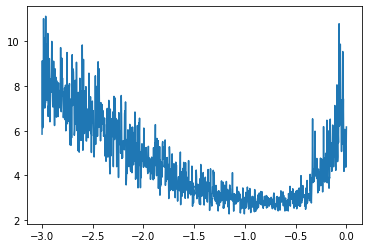

In [134]:
lri = []
lossi = []
for i in range(1000):
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))
  # forward pass
  emb = C[X[ix]]                                  # input layer 
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # hidden layer
  logits = h @ W2 + b2                        # output layer
  loss = F.cross_entropy(logits, Y[ix])

  #print(loop, '\t', loss.item())
  loop += 1
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = lrs[i]                   # get next learning rate
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lre[i])            # log exponent of learning rate
  lossi.append(loss.item())     # log corresponding log

plt.plot(lri, lossi)

## Splitting up the dataset
With big networks we tend to overfit our model (few training examples, many parameters) in other words, our network memorises our dataset. To stop this from happening, we split our dataset into three splits:
1. Training split (~80%)
2. Dev split / Validation split (~10%)
3. Test splits (~10%)

The (1) Training split is for training the dataset as above, (2) Dev split used for development over all the hyperparameters (eg. #neurons in hidden layer) of the model and (3) is for evaluating the performance of the model in the end.

If the loss with the training split and the loss with the test split are equal, we are **not** overfitting, but we are **underfitting**.

In [146]:
# build dataset

def build_dataset(words):
  block_size = 3          # number of characters used to predict the next one
  X, Y = [], []           # X: Input to the neural net, Y: Label for each example in X

  for w in words[:]:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix]    # crop and append "rolling window"

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(f'X shape: {X.shape}, Y shape: {Y.shape}')
  return X, Y

# split dataset
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))    # 80% of words
n2 = int(0.9*len(words))    # 90% of words

Xtr, Ytr = build_dataset(words[:n1])      # Training split
Xdev, Ydev = build_dataset(words[n1:n2])  # Dev split
Xte, Yte = build_dataset(words[n2:])      # Test split

X shape: torch.Size([182625, 3]), Y shape: torch.Size([182625])
X shape: torch.Size([22655, 3]), Y shape: torch.Size([22655])
X shape: torch.Size([22866, 3]), Y shape: torch.Size([22866])


In [147]:
# Set up nn
g = torch.Generator().manual_seed(2147483647)
loop = 0

# embedded look up
C = torch.randn((27, 2), generator=g, requires_grad=True)

# hidden layer of nn
W1 = torch.randn((6, 100), generator=g, requires_grad=True)   # number of inputs (3 char x 2 dim embedding = 6), hyperparameter 100 neurons
b1 = torch.randn(100, requires_grad=True)

# output layer of nn
W2 = torch.randn((100, 27), generator=g, requires_grad=True)  # 27 output neurons for every char
b2 = torch.randn(27, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

In [148]:
# training with training split
print('loop:\tloss:')

for _ in range(10000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  # forward pass
  emb = C[Xtr[ix]]                                  # input layer 
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # hidden layer
  logits = h @ W2 + b2                        # output layer
  loss = F.cross_entropy(logits, Ytr[ix])

  #print(loop, '\t', loss.item())
  loop += 1
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad

print(loop, '\t', loss.item())

loop:	loss:
10000 	 2.426156520843506


In [ ]:
# evaluate loss on training split
emb = C[Xtr]                                  # input layer 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # hidden layer
logits = h @ W2 + b2                        # output layer
loss = F.cross_entropy(logits, Ytr)
print(f'loss: {loss.item()}')

loss: 2.4940316677093506


In [149]:
# evaluate loss on dev split
emb = C[Xdev]                                  # input layer 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # hidden layer
logits = h @ W2 + b2                        # output layer
loss = F.cross_entropy(logits, Ydev)
print(f'loss: {loss.item()}')

loss: 2.4940316677093506


## Using a larger hidden layer

In [163]:
# Set up nn
g = torch.Generator().manual_seed(2147483647)
loop = 0
lossi =[]
stepi = []
hidn = 300      # number of neurons in hidden layer

# embedded look up
C = torch.randn((27, 2), generator=g, requires_grad=True)

# hidden layer of nn
W1 = torch.randn((6, hidn), generator=g, requires_grad=True)   # number of inputs (3 char x 2 dim embedding = 6), hyperparameter 100 neurons
b1 = torch.randn(hidn, requires_grad=True)

# output layer of nn
W2 = torch.randn((hidn, 27), generator=g, requires_grad=True)  # 27 output neurons for every char
b2 = torch.randn(27, requires_grad=True)

parameters = [C, W1, b1, W2, b2]
print(f'number of parameters: {sum(p.nelement() for p in parameters)}')

number of parameters: 10281


loop:	loss:
50000 	 2.231461524963379


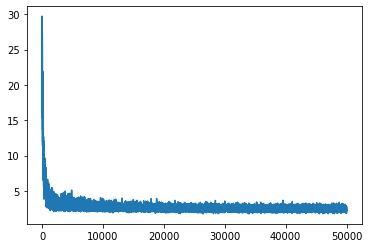

In [165]:
# training with training split
print('loop:\tloss:')

for i in range(50000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  # forward pass
  emb = C[Xtr[ix]]                                  # input layer 
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # hidden layer
  logits = h @ W2 + b2                        # output layer
  loss = F.cross_entropy(logits, Ytr[ix])

  #print(loop, '\t', loss.item())
  loop += 1
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.01 * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.item())

print(loop, '\t', loss.item())
plt.plot(stepi, lossi)

In [157]:
# evaluate loss on training split
emb = C[Xtr]                                  # input layer 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # hidden layer
logits = h @ W2 + b2                        # output layer
loss = F.cross_entropy(logits, Ytr)
print(f'loss: {loss.item()}')

loss: 2.2712228298187256


In [158]:
# evaluate loss on dev split
emb = C[Xdev]                                  # input layer 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # hidden layer
logits = h @ W2 + b2                        # output layer
loss = F.cross_entropy(logits, Ydev)
print(f'loss: {loss.item()}')

loss: 2.279073715209961


## Visualize embedding vectors
Before we start to increase embedding size, we quickly want to plot out the distribution of the datapoints of our characters. if you run the plot before and after training, you will see that a certain type of characters will always group up.

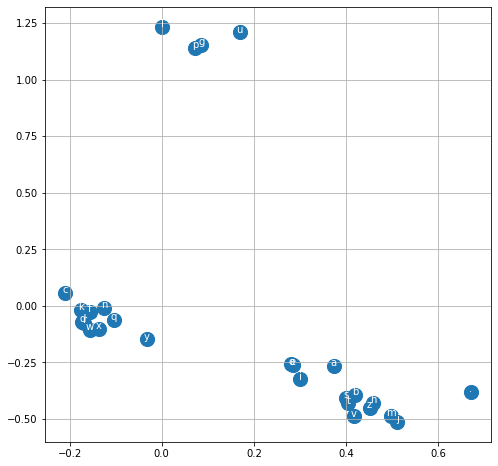

In [166]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', color='white')
plt.grid('minor')

## Using larger embedding
We are right now at a bottleneck at a loss of $2.27$. We could suspect, that the embedding size is holding us back, so now we change this size.

As we can see after running the training for some iterations, we get to a loss of $2.19$. This confirms, that the embedding size was holding us back.

In [192]:
# Set up nn
g = torch.Generator().manual_seed(2147483647)
loop = 0
lossi =[]
stepi = []
hidn = 200      # number of neurons in hidden layer
layemb = 10     # number of embedding size

# embedded look up
C = torch.randn((27, layemb), generator=g, requires_grad=True)

# hidden layer of nn
W1 = torch.randn((3*layemb, hidn), generator=g, requires_grad=True)   # number of inputs (3 char x 2 dim embedding = 6), hyperparameter 100 neurons
b1 = torch.randn(hidn, requires_grad=True)

# output layer of nn
W2 = torch.randn((hidn, 27), generator=g, requires_grad=True)  # 27 output neurons for every char
b2 = torch.randn(27, requires_grad=True)

parameters = [C, W1, b1, W2, b2]
print(f'number of parameters: {sum(p.nelement() for p in parameters)}')

number of parameters: 11897


loop:	loss:
100000 	 1.9491980075836182


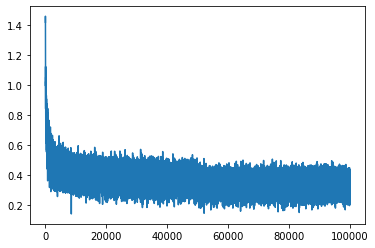

In [193]:
# training with training split
print('loop:\tloss:')

for i in range(100000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  # forward pass
  emb = C[Xtr[ix]]                                  # input layer 
  h = torch.tanh(emb.view(-1, 3*layemb) @ W1 + b1)   # hidden layer
  logits = h @ W2 + b2                        # output layer
  loss = F.cross_entropy(logits, Ytr[ix])

  #print(loop, '\t', loss.item())
  loop += 1
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 50000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loop, '\t', loss.item())
plt.plot(stepi, lossi)

In [194]:
# evaluate loss on training split
emb = C[Xtr]                                  # input layer 
h = torch.tanh(emb.view(-1, 3*layemb) @ W1 + b1)   # hidden layer
logits = h @ W2 + b2                        # output layer
loss = F.cross_entropy(logits, Ytr)
print(f'loss: {loss.item()}')

loss: 2.1736152172088623


In [195]:
# evaluate loss on dev split
emb = C[Xdev]                                  # input layer 
h = torch.tanh(emb.view(-1, 3*layemb) @ W1 + b1)   # hidden layer
logits = h @ W2 + b2                        # output layer
loss = F.cross_entropy(logits, Ydev)
print(f'loss: {loss.item()}')

loss: 2.2012739181518555


## Sample from the model

In [196]:
for _ in range(20):

  out = []
  context = [0] * block_size    # initialize '...'
  while True:
    # forward pass
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(-1, 3*layemb) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)

    # indexing
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

manos.
kaidyan.
lif.
arnikaan.
ben.
ashadanii.
retti.
macier.
izdy.
ankeleen.
zorbeellieashed.
calin.
tana.
raraizembent.
jacom.
abeyzon.
kivia.
kaenivany.
zovamadale.
karota.
